# Fine-Tuning EfficientNet

A lot of the code is from here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

ResNet-18 has around 11M trainable parameters. This is camparable to EfficientNet-b2 with ~9.2M parameters and EfficientNet-b3 with 12M parameters. See [EfficientNet paper](https://arxiv.org/abs/1905.11946) for more details.

Model | Trainable Parameters
----- | --------------
ResNet-18 | 11M
EfficientNet-b2 | 9.2M
EfficientNet-b3 | 12M

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/colab_projects/cocoapi/notebooks/

/content/drive/MyDrive/colab_projects/cocoapi/notebooks


## CONFIG

In [62]:
BACKBONE = 'efficientnet-b3'

WEIGHT_DECAY=0

DROPOUT=0.8
INTERM_NUM_FTRS=64


LAYERS_IN_HEAD = 2
if LAYERS_IN_HEAD == 2:
    assert DROPOUT is not None
    assert INTERM_NUM_FTRS is not None


MODEL_NAME = f'{BACKBONE}_{LAYERS_IN_HEAD}-layer-head_p={DROPOUT}_2021-06-17'
print(MODEL_NAME)

efficientnet-b3_2-layer-head_p=0.8_2021-06-17


## Model Descriptions

* batch size: 32
* augmentation
    * baseline train transforms: **at the beginning**
        1. resize (224x224)
        2. RandomHorizontalFlip(p=0.5)
        3. Normalize (ImageNet constants)
    * SimCLR train transforms: starting from **strong-aug-longer-Adam-2021-06-14**
        1. resize (224x224) - the only step not like in SimCLR
        2. Random Horizontal Flip
        3. Random  Color Distortion
        4. Random Gaussian Blur
    * dev transforms: **always for dev set**
        1. resize (224x224)
        2. Normalize (ImageNet constants)


### efficientnet-b2_baseline_2021-06-17

Last **1 layer** training
* **epochs: 6 (0, ..., 5)**
* optimizer: Adam(lr=1e-2)
* scheduler: StepLR(step_size=4, gamma=0.1)
* learning rate alpha:
    * epochs 0, 1, 2, 3: 1e-2
    * epochs 4, 5: 1e-3
* weight_decay=0
    
All layers training
* epochs: 10 (6, 7, ..., 15)
* optimizer: Adam(lr=1e-4)
* scheduler: StepLR(step_size=5, gamma=0.1)
* learning rate alpha:
    * epochs 6, ..., 10: 1e-4
    * epochs 11, ..., 15: 1e-5
* weight_decay=0

### efficientnet-b3_baseline_2021-06-17

Last 1 layer training
* **epochs: 6 (0, ..., 5)**
* optimizer: Adam(lr=1e-2)
* scheduler: StepLR(step_size=4, gamma=0.1)
* learning rate alpha:
    * epochs 0, 1, 2, 3: 1e-2
    * epochs 4, 5: 1e-3
* weight_decay=0
    
All layers training
* **epochs: 14 (6, 7, ..., 19)**
* optimizer: Adam(lr=1e-4)
* scheduler: StepLR(step_size=5, gamma=0.1)
* learning rate alpha:
    * **epochs 6, ..., 12: 1e-4**
    * **epochs 13, ..., 19: 1e-5**
* weight_decay=0

### efficientnet-b3_2-layer-head_p=0.8_2021-06-17

Last **2 layers** training
* **epochs: 8 (0, ..., 7)**
* optimizer: Adam(lr=1e-2)
* scheduler: StepLR(step_size=4, gamma=0.1)
* learning rate alpha:
    * **epochs 0, 1, 2, 3, 4, 5: 1e-2**
    * **epochs 6, 6: 1e-3**
* weight_decay=0
* **dropout = 0.2**
    
All layers training
* **epochs: 14 (8, 7, ..., 21)**
* optimizer: Adam(lr=1e-4)
* scheduler: StepLR(step_size=5, gamma=0.1)
* learning rate alpha:
    * **epochs 8, ..., 14: 1e-4**
    * **epochs 15, ..., 21: 1e-5**
* weight_decay=0
* **dropout = 0.8**

# Before Training

## Imports

In [5]:
import os
import copy

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms

from tqdm.notebook import trange, tqdm

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [7]:
%cd ./utils/
from dataloaders import CocoNoCropping
from config import CATEGORIES_OF_INTEREST; print(CATEGORIES_OF_INTEREST)
from config import IMG_SIZE; print(IMG_SIZE)
# help(CocoNoCropping) # should not be blank
%cd ..

/content/drive/My Drive/colab_projects/cocoapi/notebooks/utils
['bird', 'cat', 'dog', 'person']
(224, 224)
/content/drive/My Drive/colab_projects/cocoapi/notebooks


In [8]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=f89d0fad624efec973c4bcd7c7b6fe1e0a03dfa3beeddc96bb234005ba5b4cf7
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


## Transforms, Datasets, and Data Loaders

In [9]:
# Strong augmentation from SimCLR (Appendix A. Data Augmentation Details)
# https://arxiv.org/pdf/2002.05709.pdf

def get_color_distortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2) # keeps nummber of channels
    color_distort = torch.nn.Sequential(
        rnd_color_jitter,
        rnd_gray)
    
    return color_distort

def get_gaussian_blur(img_size, ratio=0.1):
    # SimCLR: ratio=0.1
    
    # calculating kernel_size and making it odd
    kernel_size = int(img_size[0] * ratio)
    if kernel_size % 2 == 0:
        kernel_size += 1
        
    # sigma=(0.1, 2.0) is default for GaussianBlur; it is also the same in Sim CLR
    gaussian_blur = transforms.GaussianBlur(kernel_size=kernel_size, sigma=(0.1, 2.0))
    
    # SimCLR: p=0.5 
    rnd_gaussian_blur = transforms.RandomApply([gaussian_blur], p=0.5)
    
    return rnd_gaussian_blur

In [10]:
baseline_train_transforms = torch.nn.Sequential(
    transforms.Resize(size=IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet constants
)


SimCLR_train_transforms = torch.nn.Sequential(
    transforms.Resize(size=IMG_SIZE), # different from SimCLR
    
    # SimCLR aug start
    transforms.RandomHorizontalFlip(),
    get_color_distortion(s=1.0),
    get_gaussian_blur(IMG_SIZE),
    # SimCLR aug end
    
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet constants
)


dev_transforms = torch.nn.Sequential(
    transforms.Resize(size=IMG_SIZE),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet constants
)

In [11]:
train1_dataset = CocoNoCropping(
    img_ids = '../my_splits/train1_ids.txt',
    my_annotations_file = '../my_annotations/imgIds_to_labels_train2017.json',
    img_dir = '../my_images/train1/',
    transform=SimCLR_train_transforms, # baseline_train_transforms
    divide_by_255=True
)

dev1_dataset = CocoNoCropping(
    img_ids = '../my_splits/dev1_ids.txt',
    my_annotations_file = '../my_annotations/imgIds_to_labels_train2017.json',
    img_dir = '../my_images/dev1/',
    transform=dev_transforms,
    divide_by_255=True
)

In [12]:
# droplast since the number of images is likely not to be divisible by batch_size
example_dataloader = DataLoader(train1_dataset, batch_size=8, shuffle=True, drop_last=True) # for visualization

train1_dataloader = DataLoader(train1_dataset, batch_size=32, shuffle=True, drop_last=True)
dev1_dataloader = DataLoader(dev1_dataset, batch_size=32, shuffle=False, drop_last=True)

## Visualize a few images

(228, 1810, 3)


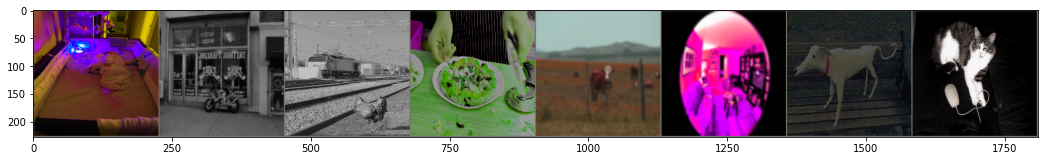

,0,1,2,3,4,5,6,7
bird,0,0,1,0,1,0,0,0
cat,0,0,0,0,0,0,0,1
dog,0,0,0,0,0,1,1,0
person,1,0,0,1,0,0,0,0


(228, 1810, 3)


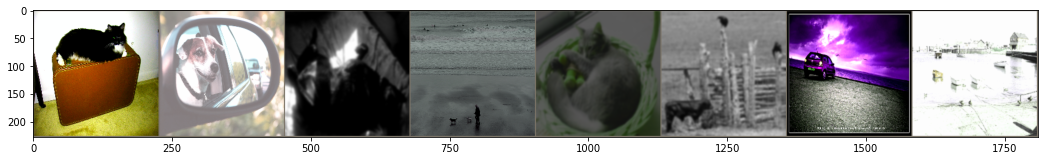

,0,1,2,3,4,5,6,7
bird,0,0,0,0,0,1,1,1
cat,1,0,0,0,1,0,0,0
dog,0,1,1,1,0,0,0,0
person,0,0,0,1,0,0,0,0


(228, 1810, 3)


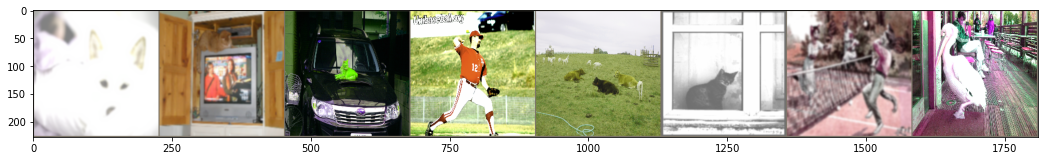

,0,1,2,3,4,5,6,7
bird,0,0,0,0,0,0,0,1
cat,0,1,1,0,0,1,1,0
dog,1,0,0,0,0,0,0,0
person,1,1,0,1,0,0,0,1


(228, 1810, 3)


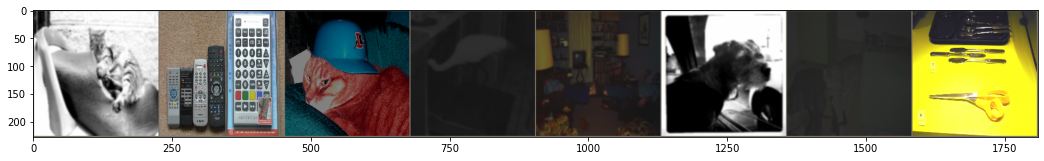

,0,1,2,3,4,5,6,7
bird,0,0,0,1,0,0,0,0
cat,1,0,1,0,0,0,1,0
dog,0,0,0,0,0,1,0,0
person,0,0,0,0,1,0,0,0


(228, 1810, 3)


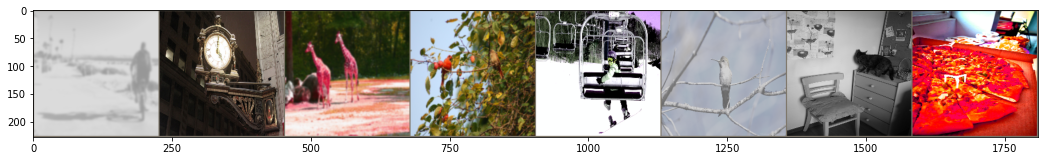

,0,1,2,3,4,5,6,7
bird,1,0,0,1,0,1,1,0
cat,0,0,0,0,0,0,1,0
dog,0,0,0,0,0,0,0,0
person,1,0,0,0,1,0,0,0


(228, 1810, 3)


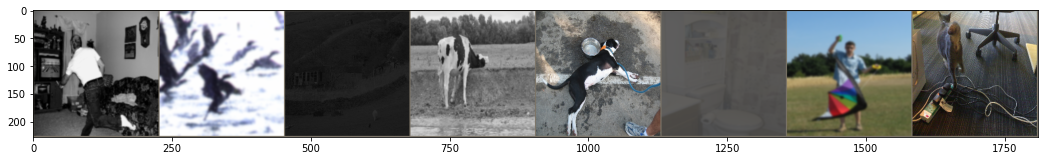

,0,1,2,3,4,5,6,7
bird,0,1,1,0,0,0,0,0
cat,0,0,0,0,0,0,0,1
dog,0,0,0,0,1,0,0,0
person,1,0,0,0,1,0,1,0


In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    
    # ImageNet constants
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


LIMIT = 5
for i, batch in enumerate(example_dataloader):
    inputs, labels = batch['image'], batch['label']

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    plt.subplots(figsize=(18, 3))
    imshow(out)

    display(pd.DataFrame({CATEGORIES_OF_INTEREST[i]: labels[i].numpy() for i in range(len(labels))}).T)
    
    if i == LIMIT:
        break

## Training and Validation Loops

In [14]:
def train_one_epoch(iterator, model, criterion, optimizer):
    total = 0
    epoch_loss = 0
    per_class_correct = torch.zeros(4)
    
    for batch in tqdm(iterator, desc='train'):
        model.train()

        inputs = batch['image'].to(device) # [batch size, channel, h, w]
        #print(inputs.shape, inputs.dtype)
        # right now, `labels` is a list with num_classes tensors, each tensor with batch_size of labels (integers)
        labels = torch.vstack(batch['label']).T.contiguous().to(torch.float32).to(device)
        #print(labels.shape, labels.dtype, labels.is_contiguous()) # labels
        total += labels.shape[0]
        
        optimizer.zero_grad()

        outputs = model(inputs) #logits
        #print(outputs.shape, outputs.dtype, outputs.is_contiguous())
        #print(outputs)

        loss = criterion(outputs, labels)
        epoch_loss += loss.item() # no need to drag 
        #print(loss.item())

        loss.backward()
        optimizer_ft.step()

        preds = (outputs > 0.5).detach().to(torch.int32) # no need to drag the gradients
        #print(preds)
        per_class_correct += (preds.cpu() == labels.cpu()).sum(0) # 0-th axis for batch_size
        #print(per_class_correct)
    
    avg_epoch_loss = epoch_loss / total
    avg_per_class_acc = per_class_correct / total
    
    return avg_epoch_loss, avg_per_class_acc

In [15]:
def evaluate(iterator, model, criterion):
    total = 0
    epoch_loss = 0
    per_class_correct = torch.zeros(4)
    
    for batch in tqdm(iterator, desc='dev'):
        
        # no need for gradients, batch-norm and dropout in evaluation mode
        model.eval()
        with torch.no_grad():
            
            inputs = batch['image'].to(device) # [batch size, channel, h, w]
            #print(inputs.shape, inputs.dtype)
            # right now, `labels` is a list with num_classes tensors, each tensor with batch_size of labels (integers)
            labels = torch.vstack(batch['label']).T.contiguous().to(torch.float32).to(device)
            #print(labels.shape, labels.dtype, labels.is_contiguous()) # labels
            total += labels.shape[0]

            outputs = model(inputs) #logits
            #print(outputs.shape, outputs.dtype, outputs.is_contiguous())
            #print(outputs)

            loss = criterion(outputs, labels)
            epoch_loss += loss.item() # no need to drag 
            #print(loss.item())

            preds = (outputs > 0.5).detach().to(torch.int32) # no need to drag the gradients
            #print(preds)
            per_class_correct += (preds.cpu() == labels.cpu()).sum(0) # 0-th axis for batch_size
            #print(per_class_correct)
    
    avg_epoch_loss = epoch_loss / total
    avg_per_class_acc = per_class_correct / total
    
    return avg_epoch_loss, avg_per_class_acc

# Training

## Fine-tune only the last layer (2 layers) and save (no overfitting here)

In [63]:
device

'cuda:0'

In [80]:
# load pre-trained model
model_ft = EfficientNet.from_pretrained(BACKBONE)

# freese all parameters
for param in model_ft.parameters():
    param.requires_grad = False


# replace the prediction head to fit the task
#
# check how many features are just before the head
num_ftrs = model_ft._fc.in_features
print('Num features before the head:', num_ftrs)
#
# replace head
if LAYERS_IN_HEAD == 1:
    # replace with only 1 layer
    model_ft._fc = torch.nn.Linear(num_ftrs, len(CATEGORIES_OF_INTEREST))
elif LAYERS_IN_HEAD == 2:
    # replace with 2 layers like in SimCLR
    print('Num intermediate features:', INTERM_NUM_FTRS)
    
    model_ft._fc = torch.nn.Sequential(
        torch.nn.Linear(num_ftrs, INTERM_NUM_FTRS),
        torch.nn.Dropout(p=0.2), # smaller dropout
        torch.nn.Linear(INTERM_NUM_FTRS, len(CATEGORIES_OF_INTEREST))
    )
else:
    # break
    print(1/0)
print('Num outputs:', len(CATEGORIES_OF_INTEREST))

# unfreeeze model parameters of model head
for param in model_ft._fc.parameters():
    param.requires_grad = True

# place it on the device
model_ft = model_ft.to(device)

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.01) # weight_decay=WEIGHT_DECAY

# Decay LR by a factor of `gamma` every `step_size` epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

Loaded pretrained weights for efficientnet-b3
Num features before the head: 1536
Num intermediate features: 64
Num outputs: 4


In [81]:
#model_ft

Epoch: 0



Train Avg Acc: 0.7605469226837158
Train Loss: 2.322360861301422
Train Accs per class: tensor([0.8000, 0.8000, 0.7609, 0.6812])




Dev Avg Acc: 0.7867187261581421
Dev Loss: 2.0775954246521
Dev Accs per class: tensor([0.7469, 0.8641, 0.7688, 0.7672])


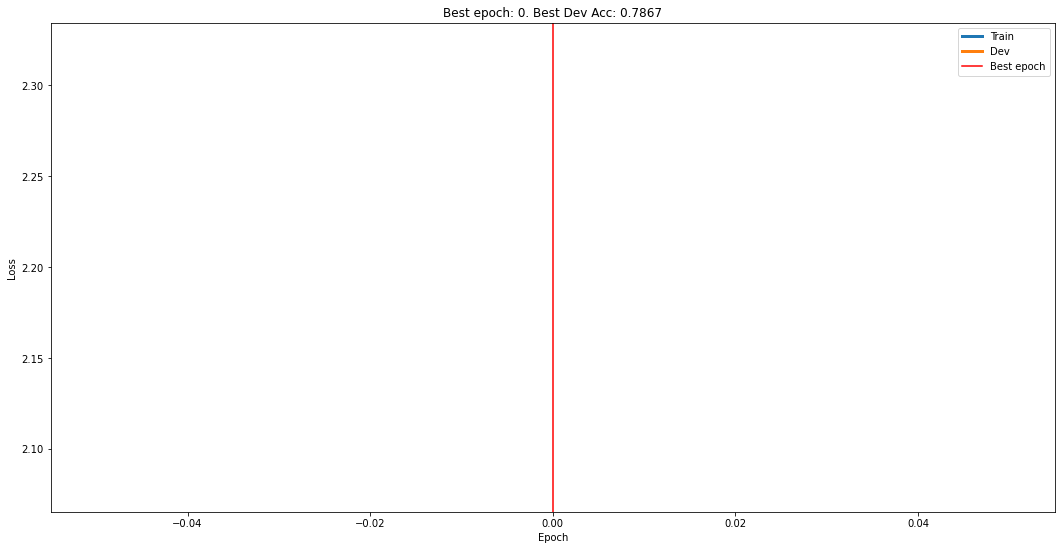


--------------------------------------------------------------------------------

Epoch: 1



Train Avg Acc: 0.8066406846046448
Train Loss: 1.821561485528946
Train Accs per class: tensor([0.8359, 0.8562, 0.7953, 0.7391])




Dev Avg Acc: 0.8058594465255737
Dev Loss: 1.8933295249938964
Dev Accs per class: tensor([0.8141, 0.8781, 0.7953, 0.7359])


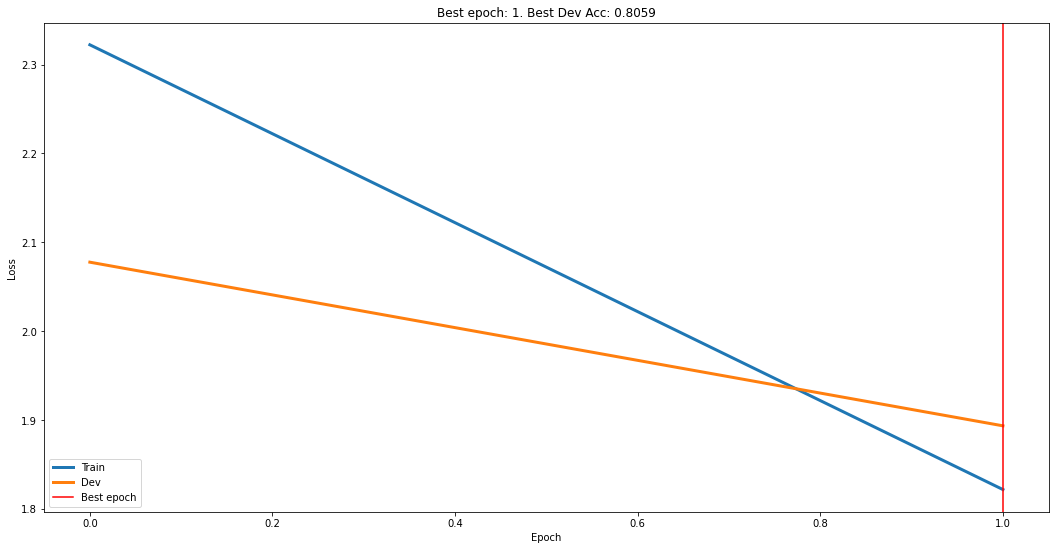


--------------------------------------------------------------------------------

Epoch: 2



Train Avg Acc: 0.818359375
Train Loss: 1.7237561821937561
Train Accs per class: tensor([0.8359, 0.8750, 0.7828, 0.7797])




Dev Avg Acc: 0.8214843273162842
Dev Loss: 1.8431779742240906
Dev Accs per class: tensor([0.8359, 0.8813, 0.8094, 0.7594])


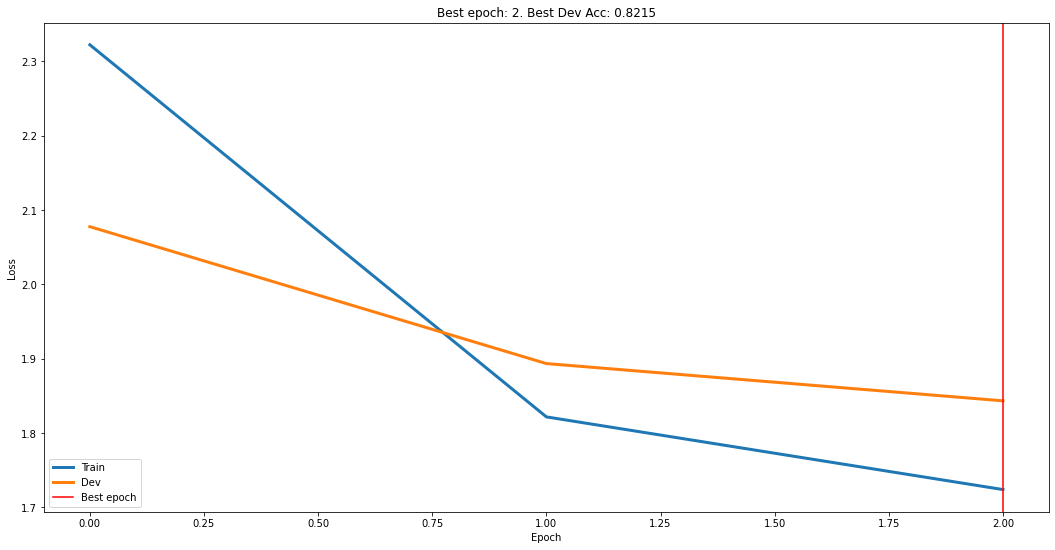


--------------------------------------------------------------------------------

Epoch: 3



Train Avg Acc: 0.826171875
Train Loss: 1.66316260099411
Train Accs per class: tensor([0.8391, 0.8687, 0.8141, 0.7828])




Dev Avg Acc: 0.815234363079071
Dev Loss: 1.8514055490493775
Dev Accs per class: tensor([0.8297, 0.8797, 0.8172, 0.7344])


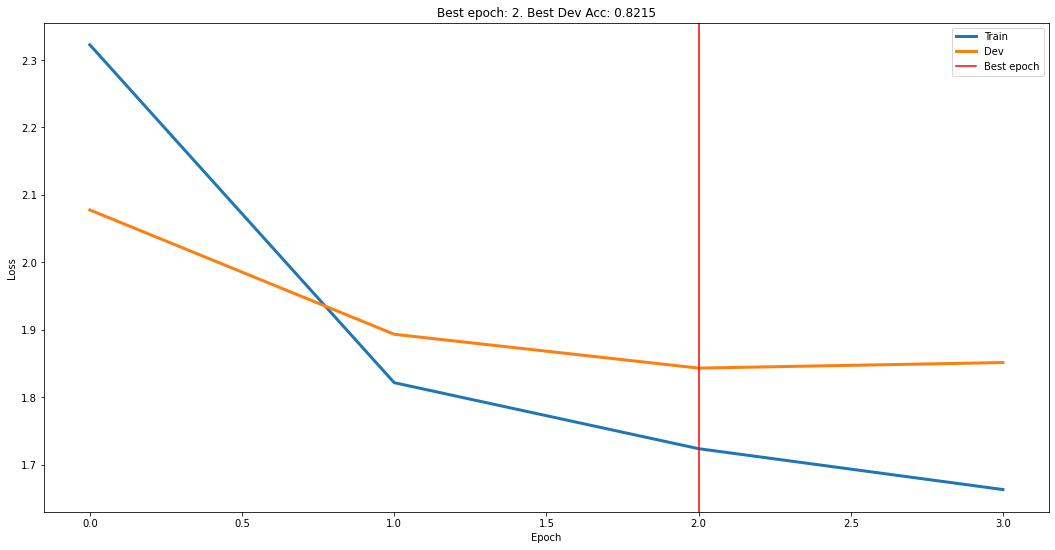


--------------------------------------------------------------------------------

Epoch: 4



Train Avg Acc: 0.8234374523162842
Train Loss: 1.6501615583896636
Train Accs per class: tensor([0.8484, 0.8734, 0.7922, 0.7797])




Dev Avg Acc: 0.814453125
Dev Loss: 1.822117817401886
Dev Accs per class: tensor([0.8359, 0.8766, 0.7984, 0.7469])


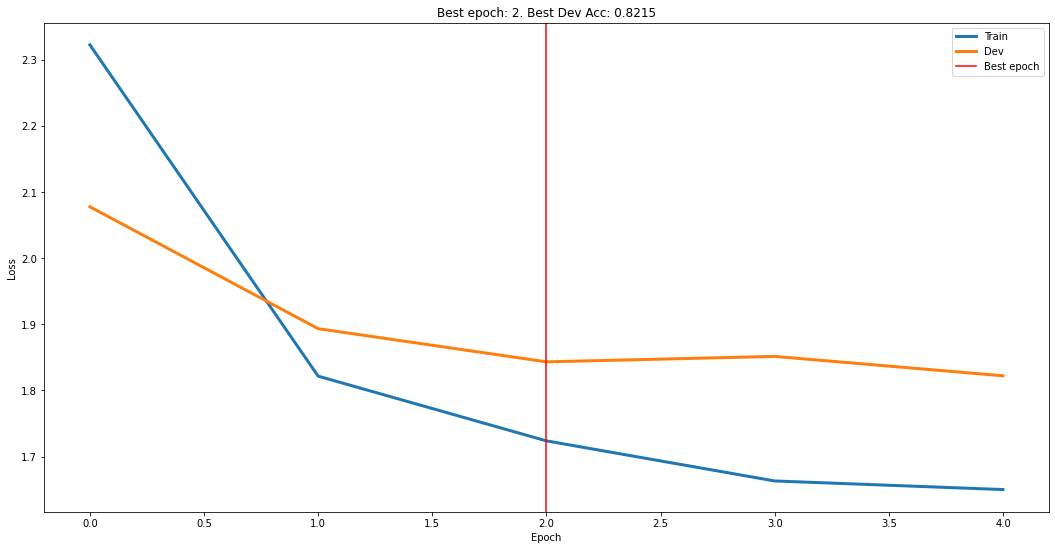


--------------------------------------------------------------------------------

Epoch: 5



Train Avg Acc: 0.8226562738418579
Train Loss: 1.6742138147354126
Train Accs per class: tensor([0.8203, 0.8625, 0.8281, 0.7797])




Dev Avg Acc: 0.8296874761581421
Dev Loss: 1.6916698515415192
Dev Accs per class: tensor([0.8578, 0.8906, 0.8172, 0.7531])


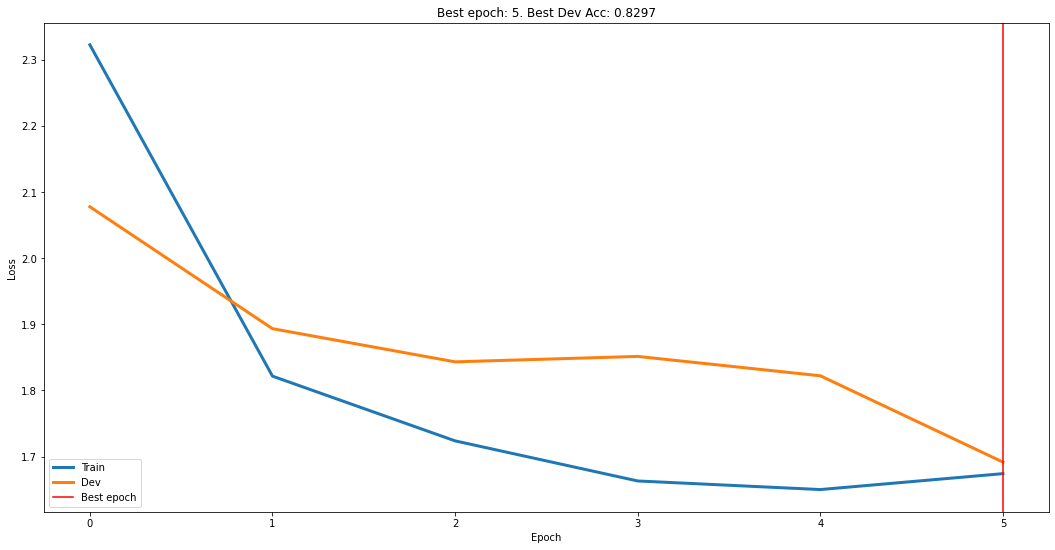


--------------------------------------------------------------------------------

Epoch: 6



Train Avg Acc: 0.8433593511581421
Train Loss: 1.5162902295589447
Train Accs per class: tensor([0.8609, 0.8687, 0.8516, 0.7922])




Dev Avg Acc: 0.8257812261581421
Dev Loss: 1.6507234752178193
Dev Accs per class: tensor([0.8484, 0.8875, 0.8078, 0.7594])


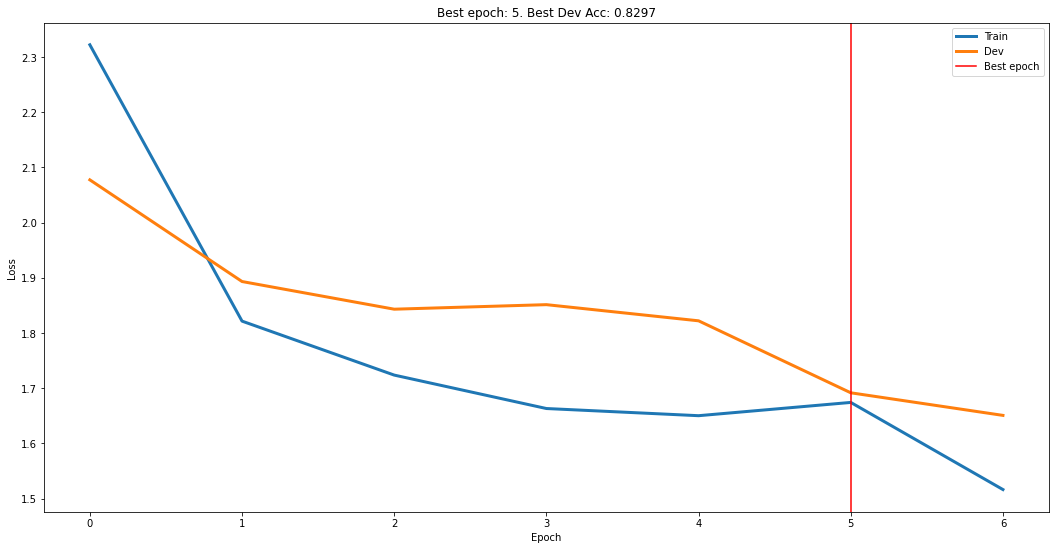


--------------------------------------------------------------------------------

Epoch: 7



Train Avg Acc: 0.8449218273162842
Train Loss: 1.4519225120544434
Train Accs per class: tensor([0.8500, 0.8719, 0.8453, 0.8125])




Dev Avg Acc: 0.826953113079071
Dev Loss: 1.6362990617752076
Dev Accs per class: tensor([0.8406, 0.8953, 0.8109, 0.7609])


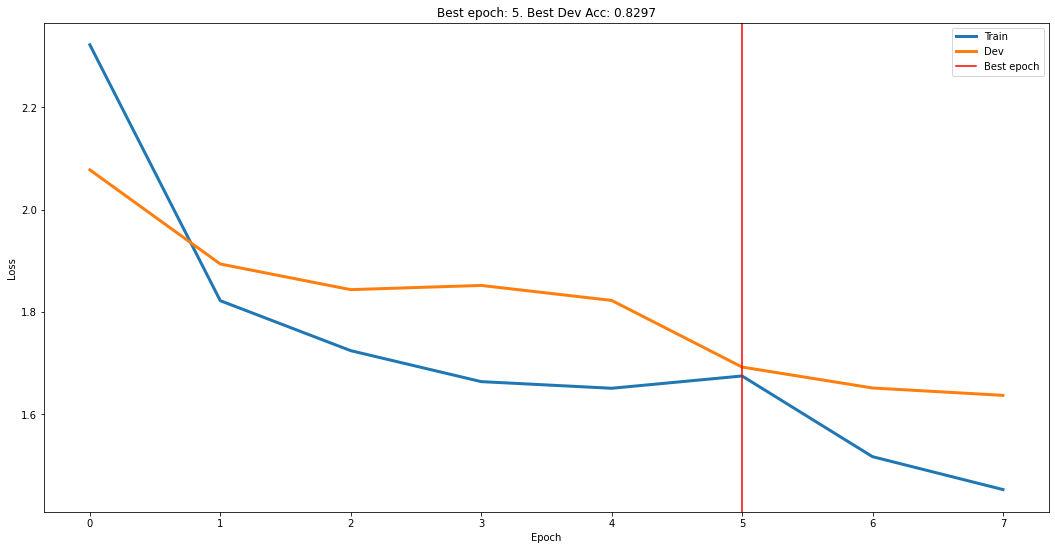


--------------------------------------------------------------------------------


CPU times: user 6min 10s, sys: 7.09 s, total: 6min 17s
Wall time: 6min 29s


In [82]:
%%time
last_layer_num_epochs = 8

train_epoch_loss_history = []
train_per_class_acc_history = []

dev_epoch_loss_history = []
dev_per_class_acc_history = []

dev_epoch_acc_history = []
train_epoch_acc_history = []

best_acc = None
best_epoch = None

best_model_wts = copy.deepcopy(model_ft.state_dict())

for epoch in trange(last_layer_num_epochs, desc='epoch'):
    print('Epoch:', epoch)
    # train
    avg_epoch_loss, avg_per_class_acc = train_one_epoch(iterator=train1_dataloader,
                                                        model=model_ft, criterion=criterion,
                                                        optimizer=optimizer_ft)
    avg_acc = avg_per_class_acc.mean().item()
    train_epoch_acc_history.append(avg_acc)
    print('Train Avg Acc:', avg_acc)
    train_epoch_loss_history.append(avg_epoch_loss)
    train_per_class_acc_history.append(avg_per_class_acc)
    print('Train Loss:', avg_epoch_loss)
    print('Train Accs per class:', avg_per_class_acc)
    print()
    
    # evaluate on the dev set
    avg_epoch_loss, avg_per_class_acc = evaluate(iterator=dev1_dataloader,
                                                 model=model_ft, criterion=criterion)
    avg_acc = avg_per_class_acc.mean().item()
    dev_epoch_acc_history.append(avg_acc)
    print('Dev Avg Acc:', avg_acc)
    dev_epoch_loss_history.append(avg_epoch_loss)
    dev_per_class_acc_history.append(avg_per_class_acc)
    print('Dev Loss:', avg_epoch_loss)
    print('Dev Accs per class:', avg_per_class_acc)
    
    
        
    if (not best_acc) or avg_acc > best_acc:
        best_epoch = epoch
        best_acc = avg_acc
        
        best_model_wts = copy.deepcopy(model_ft.state_dict())

    # lr scheduler step
    exp_lr_scheduler.step()

    # plot
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_epoch_loss_history)), train_epoch_loss_history, label=f'Train', linewidth=3)
    plt.plot(np.arange(len(dev_epoch_loss_history)), dev_epoch_loss_history, label=f'Dev', linewidth=3)
    plt.axvline(x=best_epoch, label='Best epoch', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Best epoch: {best_epoch}. Best Dev Acc: {best_acc:.4}')
    plt.legend(loc='best')
    plt.show()


    print()
    print('-'*80)
    print()

### Save the model with the last layer fine-tuned - this does not change.

In [83]:
LL_FINE_TUNED_MODEL_NAME = f'{BACKBONE}_{LAYERS_IN_HEAD}-layer-head-finetuned'
print(LL_FINE_TUNED_MODEL_NAME)
LL_FINE_TUNED_MODEL_PATH = f'../weights/{LL_FINE_TUNED_MODEL_NAME}.pth'
torch.save(model_ft.state_dict(), LL_FINE_TUNED_MODEL_PATH)

history = {
    'train_losses': [float(el) for el in train_epoch_loss_history],
    'dev_losses': [float(el) for el in dev_epoch_loss_history],

    'train_per_class_accuracies': [list(el.numpy().astype(float)) for el in train_per_class_acc_history],
    'dev_per_class_accuracies': [list(el.numpy().astype(float)) for el in dev_per_class_acc_history],

    'train_average_accuracies': [float(el) for el in train_epoch_acc_history],
    'dev_average_accuracies': [float(el) for el in dev_epoch_acc_history],
    
    'best_epoch': best_epoch,
    'best_acc': best_acc
}

with open(f'../history/{LL_FINE_TUNED_MODEL_NAME}.json', 'w') as f:
    json.dump(history, f)

# # load history
# with open(f'../history/{LL_FINE_TUNED_MODEL_NAME}.json') as f:
#     history = json.load(f)

# history

efficientnet-b3_2-layer-head-finetuned


In [84]:
# load the fine-tuned model parameters
model_ft.load_state_dict(torch.load(LL_FINE_TUNED_MODEL_PATH))
print(evaluate(iterator=dev1_dataloader, model=model_ft, criterion=criterion))


(1.6362990617752076, tensor([0.8406, 0.8953, 0.8109, 0.7609]))


## Fine-tune all layers with lower learning rate

In [85]:
device

'cuda:0'

In [86]:
# change dropout probability for 2-layer-head models
if LAYERS_IN_HEAD == 2:
    model_ft._fc = torch.nn.Sequential(
        torch.nn.Linear(num_ftrs, INTERM_NUM_FTRS),
        torch.nn.Dropout(p=DROPOUT), # p - dropout probability
        torch.nn.Linear(INTERM_NUM_FTRS, len(CATEGORIES_OF_INTEREST))
    )


model_ft.load_state_dict(torch.load(LL_FINE_TUNED_MODEL_PATH))

# unfreese all parameters
for param in model_ft.parameters():
    param.requires_grad = True

# place it on the device
model_ft = model_ft.to(device)

# criterion and optimizer
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=WEIGHT_DECAY)

# Decay LR by a factor of `gamma` every `step_size` epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [87]:
print(MODEL_NAME)
print(evaluate(iterator=dev1_dataloader, model=model_ft, criterion=criterion))

efficientnet-b3_2-layer-head_p=0.8_2021-06-17



(1.6362990617752076, tensor([0.8406, 0.8953, 0.8109, 0.7609]))


In [88]:
# load history from the last-layer fine-tuned model
with open(f'../history/{LL_FINE_TUNED_MODEL_NAME}.json') as f:
    history = json.load(f)
#history

Epoch: 8



Train Avg Acc: 0.7953125238418579
Train Loss: 1.9928017437458039
Train Accs per class: tensor([0.8281, 0.8188, 0.7984, 0.7359])




Dev Avg Acc: 0.8363281488418579
Dev Loss: 1.5772784948349
Dev Accs per class: tensor([0.8484, 0.8953, 0.8109, 0.7906])


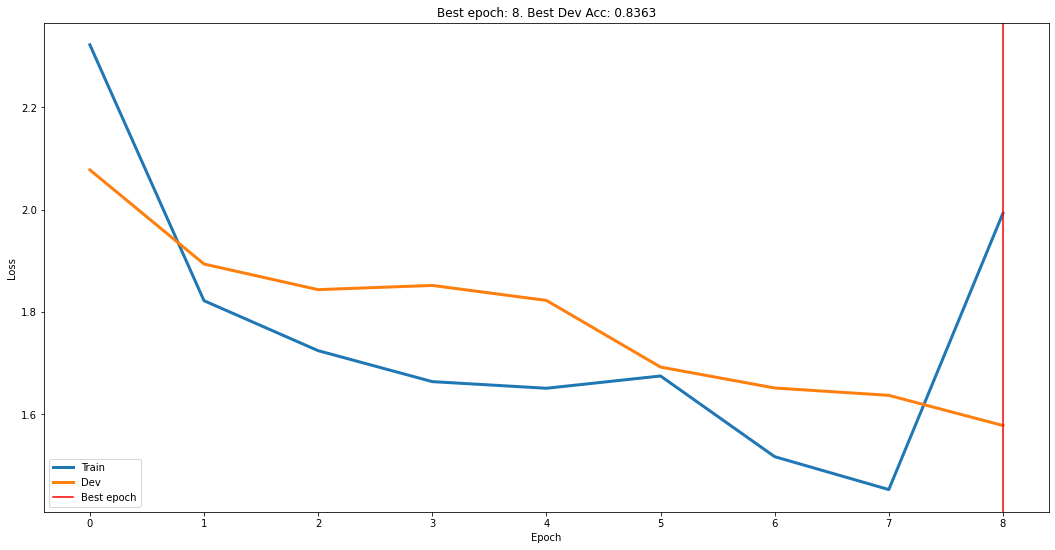


--------------------------------------------------------------------------------

Epoch: 9



Train Avg Acc: 0.8328124284744263
Train Loss: 1.6422587454319
Train Accs per class: tensor([0.8281, 0.8859, 0.8219, 0.7953])




Dev Avg Acc: 0.841015636920929
Dev Loss: 1.5460002720355988
Dev Accs per class: tensor([0.8469, 0.9000, 0.8078, 0.8094])


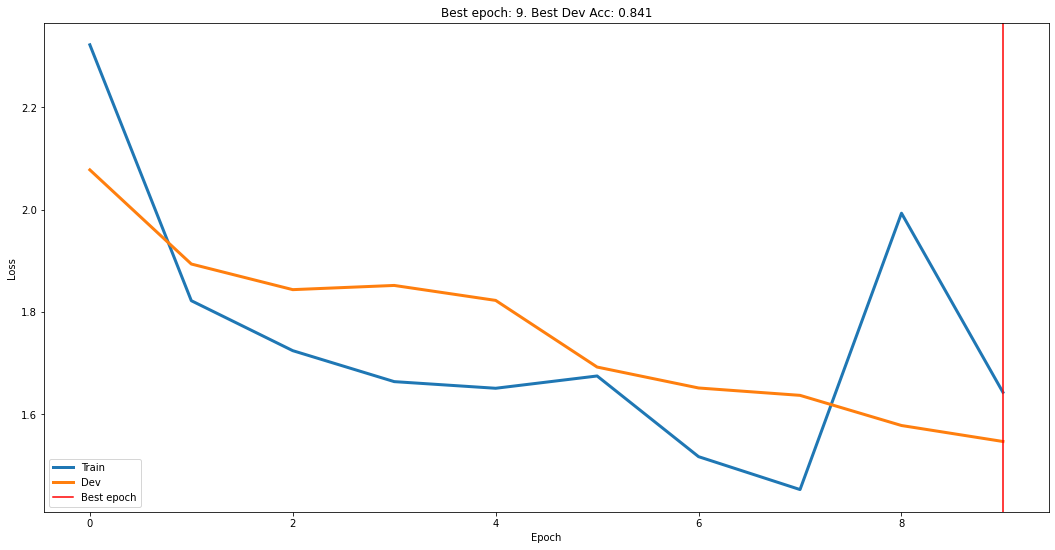


--------------------------------------------------------------------------------

Epoch: 10



Train Avg Acc: 0.8246093988418579
Train Loss: 1.6463658392429352
Train Accs per class: tensor([0.8109, 0.8531, 0.8406, 0.7937])




Dev Avg Acc: 0.84375
Dev Loss: 1.512132316827774
Dev Accs per class: tensor([0.8609, 0.9047, 0.8047, 0.8047])


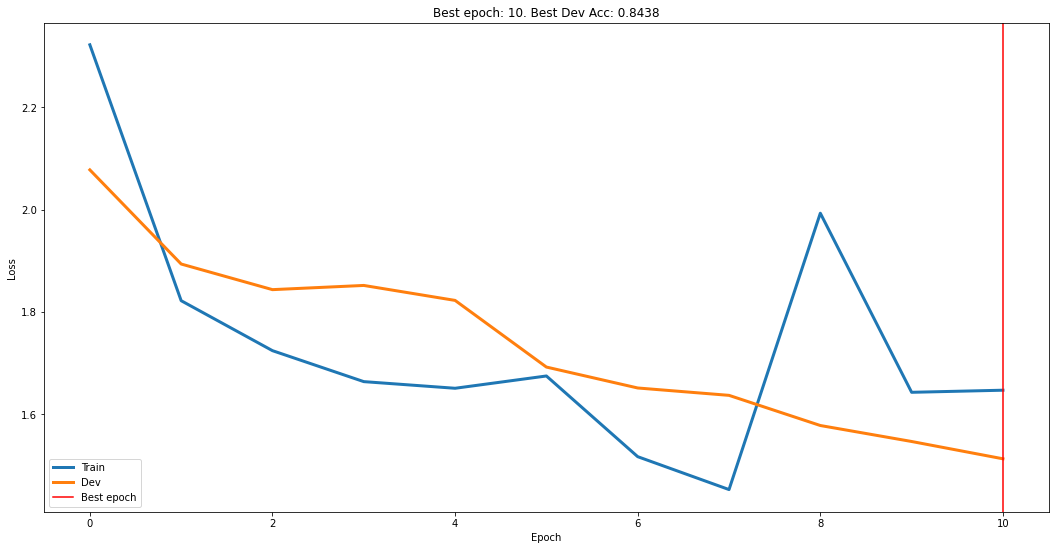


--------------------------------------------------------------------------------

Epoch: 11



Train Avg Acc: 0.8558593392372131
Train Loss: 1.4655262351036071
Train Accs per class: tensor([0.8734, 0.8891, 0.8375, 0.8234])




Dev Avg Acc: 0.850390613079071
Dev Loss: 1.481831580400467
Dev Accs per class: tensor([0.8625, 0.9094, 0.8094, 0.8203])


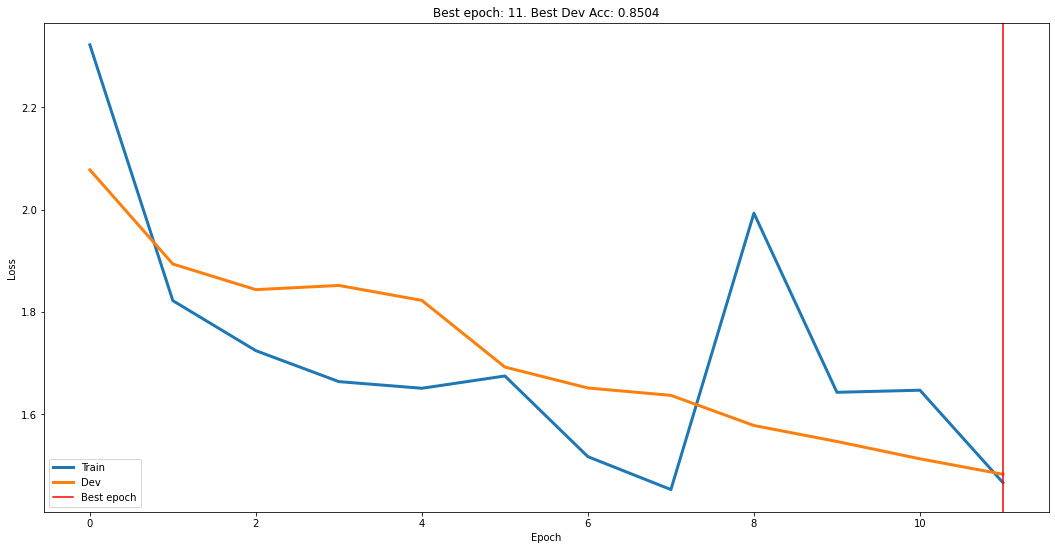


--------------------------------------------------------------------------------

Epoch: 12



Train Avg Acc: 0.8472656011581421
Train Loss: 1.463290247321129
Train Accs per class: tensor([0.8422, 0.8766, 0.8578, 0.8125])




Dev Avg Acc: 0.8539062142372131
Dev Loss: 1.4593710154294968
Dev Accs per class: tensor([0.8625, 0.9062, 0.8234, 0.8234])


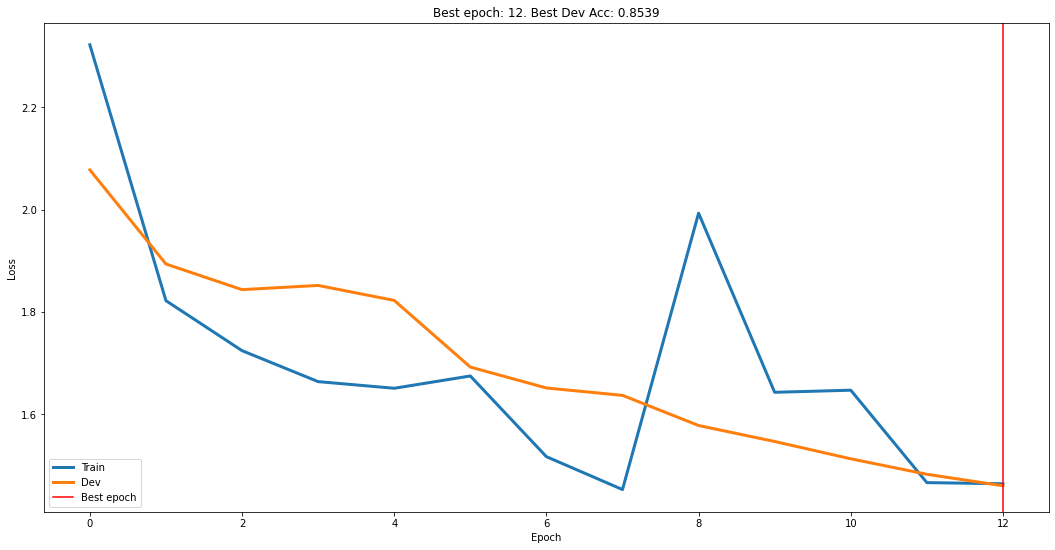


--------------------------------------------------------------------------------

Epoch: 13



Train Avg Acc: 0.8597656488418579
Train Loss: 1.3638735115528107
Train Accs per class: tensor([0.8766, 0.8953, 0.8687, 0.7984])




Dev Avg Acc: 0.8578124642372131
Dev Loss: 1.4260802835226059
Dev Accs per class: tensor([0.8672, 0.9000, 0.8250, 0.8391])


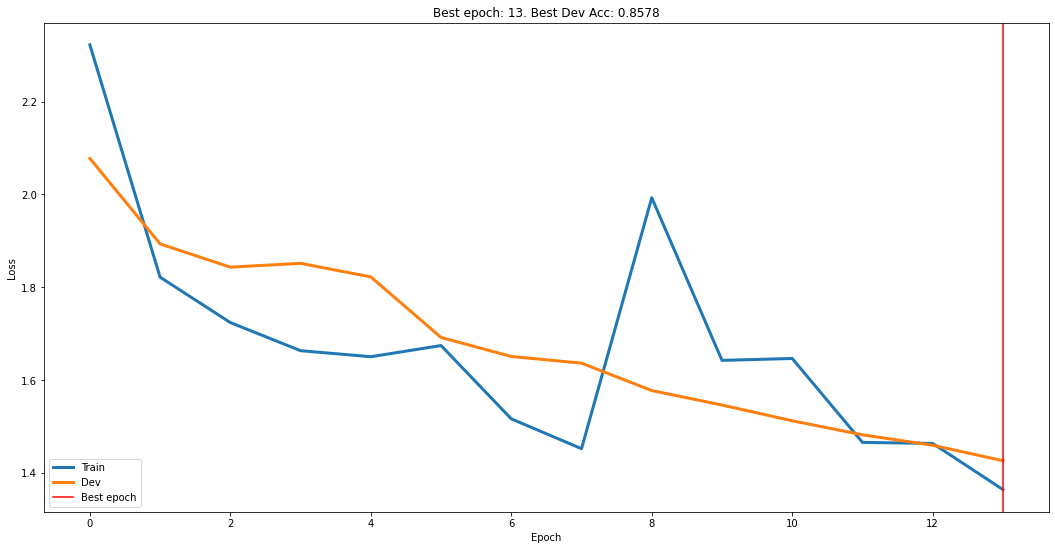


--------------------------------------------------------------------------------

Epoch: 14



Train Avg Acc: 0.869921863079071
Train Loss: 1.2843378335237503
Train Accs per class: tensor([0.8906, 0.8828, 0.8703, 0.8359])




Dev Avg Acc: 0.8609374761581421
Dev Loss: 1.4113034784793854
Dev Accs per class: tensor([0.8641, 0.9047, 0.8297, 0.8453])


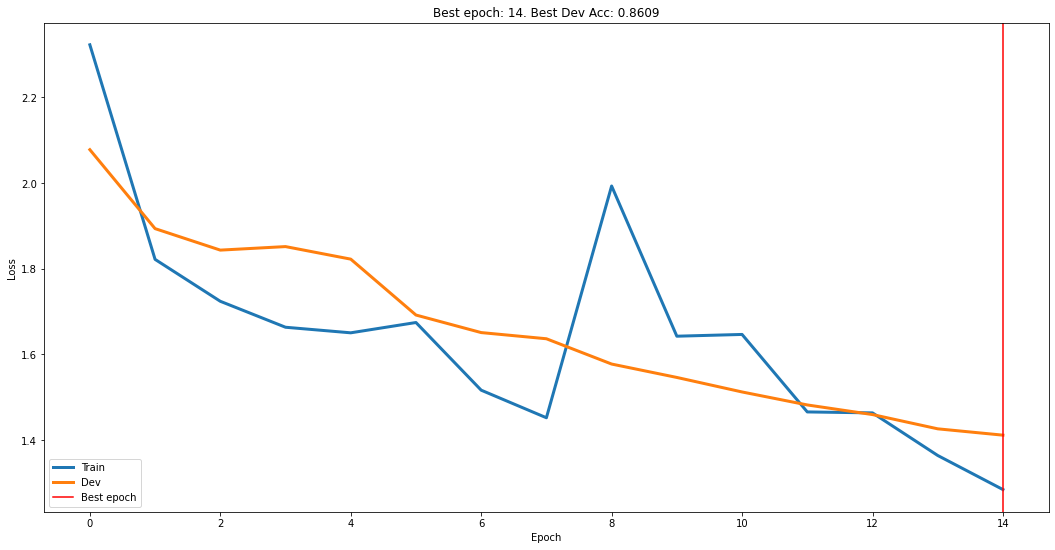


--------------------------------------------------------------------------------

Epoch: 15



Train Avg Acc: 0.8792968988418579
Train Loss: 1.138988482952118
Train Accs per class: tensor([0.8687, 0.9125, 0.8766, 0.8594])




Dev Avg Acc: 0.8589843511581421
Dev Loss: 1.4083669304847717
Dev Accs per class: tensor([0.8641, 0.9016, 0.8281, 0.8422])


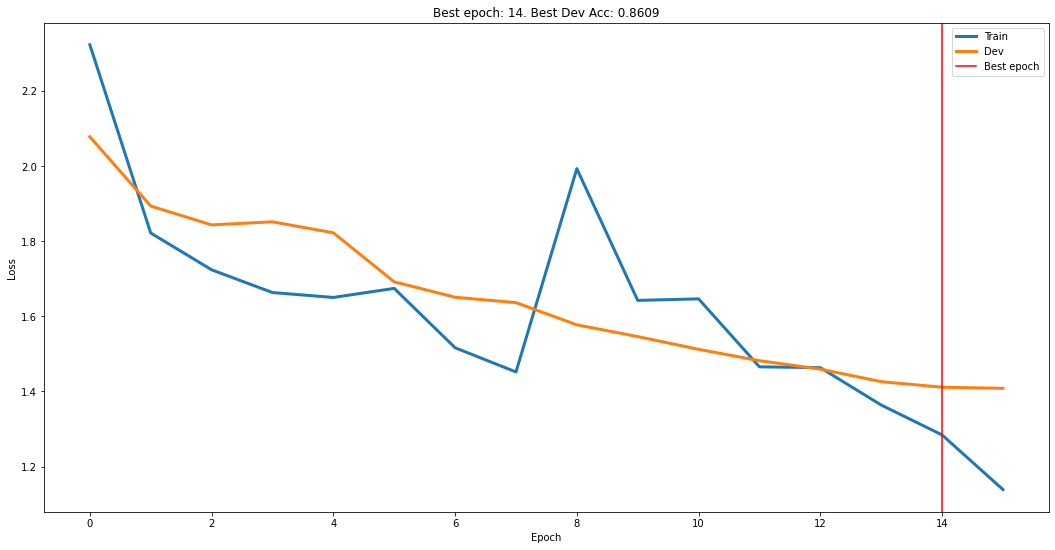


--------------------------------------------------------------------------------

Epoch: 16



Train Avg Acc: 0.8828125
Train Loss: 1.1657961040735245
Train Accs per class: tensor([0.9000, 0.9109, 0.8750, 0.8453])




Dev Avg Acc: 0.858593761920929
Dev Loss: 1.4063498437404633
Dev Accs per class: tensor([0.8625, 0.9047, 0.8281, 0.8391])


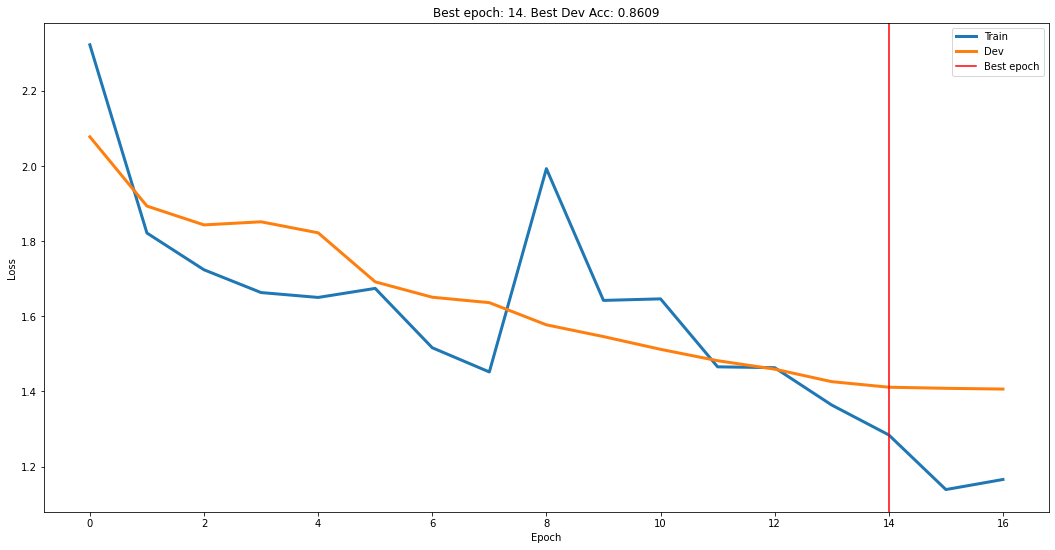


--------------------------------------------------------------------------------

Epoch: 17



Train Avg Acc: 0.881640613079071
Train Loss: 1.1627623945474626
Train Accs per class: tensor([0.8813, 0.9125, 0.8844, 0.8484])




Dev Avg Acc: 0.858203113079071
Dev Loss: 1.4036104261875153
Dev Accs per class: tensor([0.8625, 0.9047, 0.8266, 0.8391])


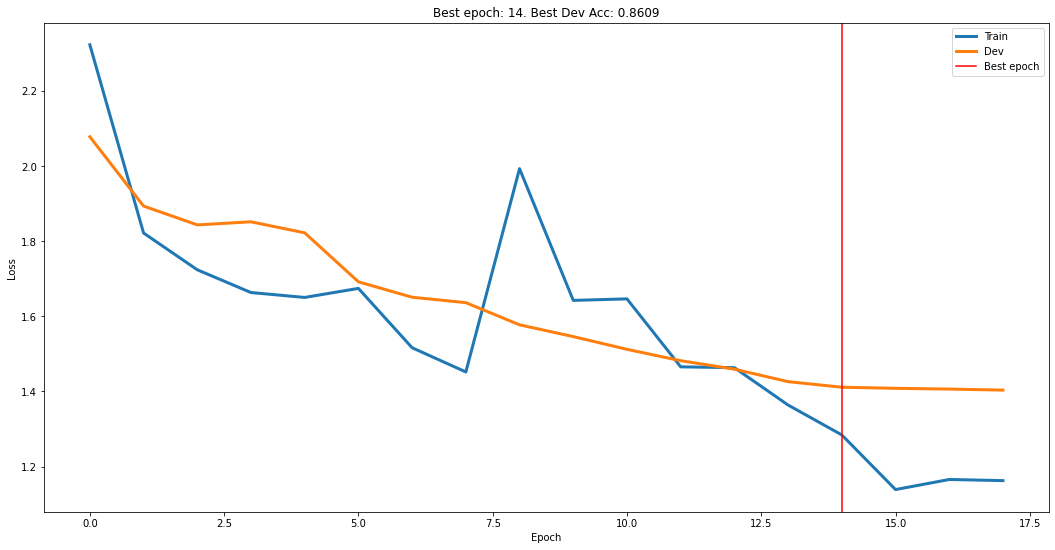


--------------------------------------------------------------------------------

Epoch: 18



Train Avg Acc: 0.87890625
Train Loss: 1.23526528775692
Train Accs per class: tensor([0.8875, 0.8969, 0.8781, 0.8531])




Dev Avg Acc: 0.859375
Dev Loss: 1.402833139896393
Dev Accs per class: tensor([0.8625, 0.9062, 0.8250, 0.8438])


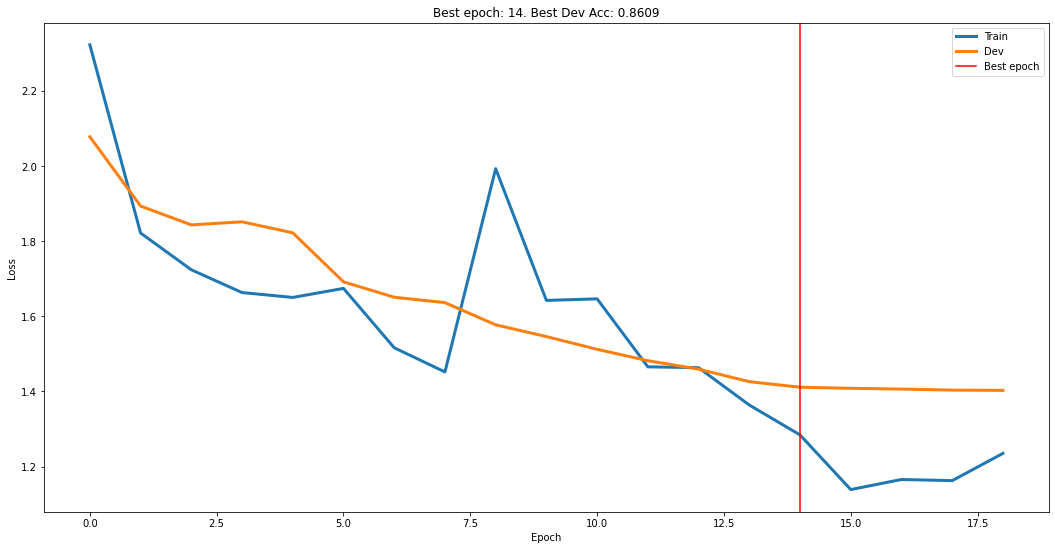


--------------------------------------------------------------------------------

Epoch: 19



Train Avg Acc: 0.8812500238418579
Train Loss: 1.177346619963646
Train Accs per class: tensor([0.8859, 0.9047, 0.8766, 0.8578])




Dev Avg Acc: 0.857421875
Dev Loss: 1.4020874738693236
Dev Accs per class: tensor([0.8609, 0.9031, 0.8234, 0.8422])


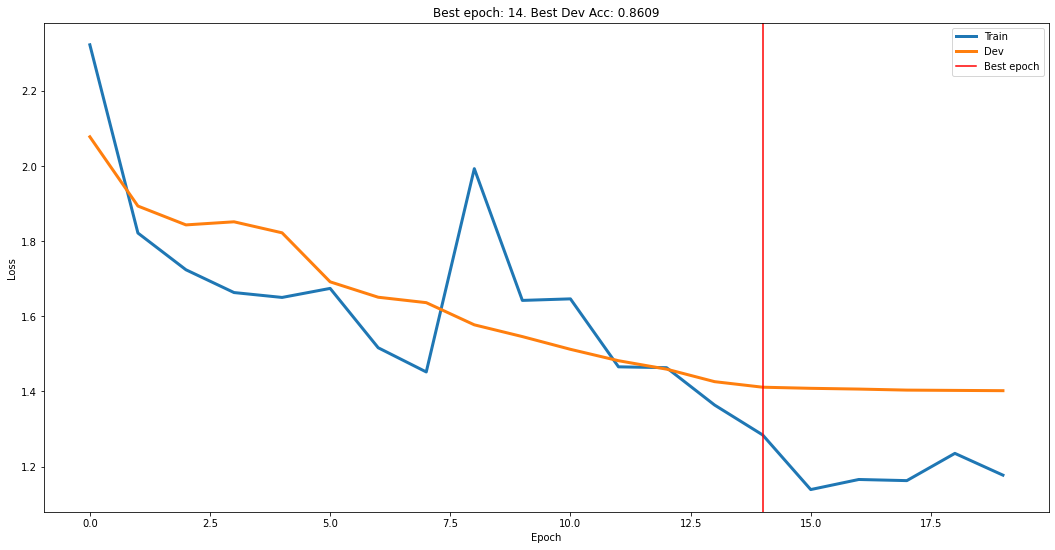


--------------------------------------------------------------------------------

Epoch: 20



Train Avg Acc: 0.87890625
Train Loss: 1.1719866216182708
Train Accs per class: tensor([0.8719, 0.9109, 0.8781, 0.8547])




Dev Avg Acc: 0.8578124642372131
Dev Loss: 1.3997580885887146
Dev Accs per class: tensor([0.8641, 0.9047, 0.8219, 0.8406])


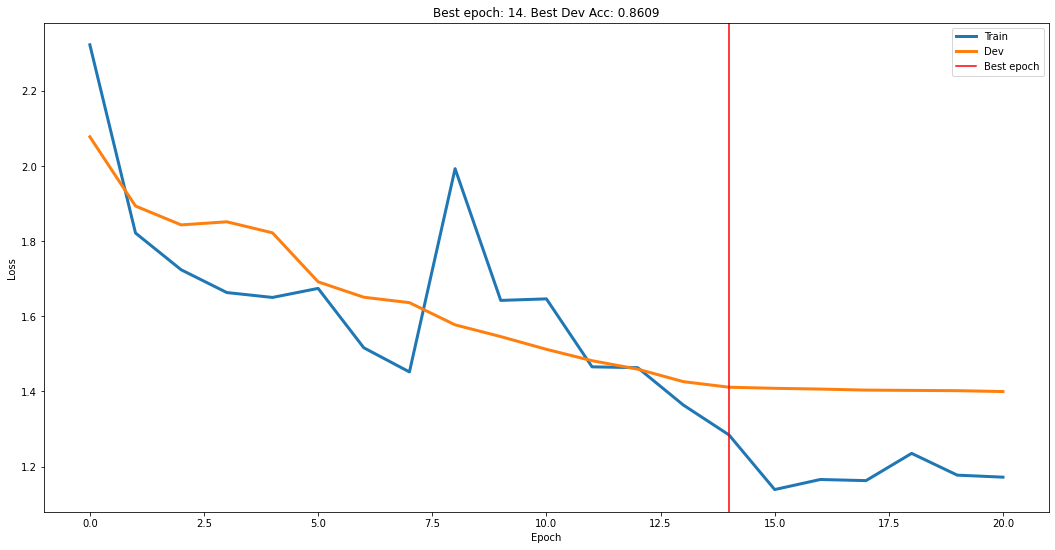


--------------------------------------------------------------------------------

Epoch: 21



Train Avg Acc: 0.8757812976837158
Train Loss: 1.1880616903305055
Train Accs per class: tensor([0.8672, 0.9203, 0.8813, 0.8344])




Dev Avg Acc: 0.8585937023162842
Dev Loss: 1.3981910586357116
Dev Accs per class: tensor([0.8656, 0.9031, 0.8219, 0.8438])


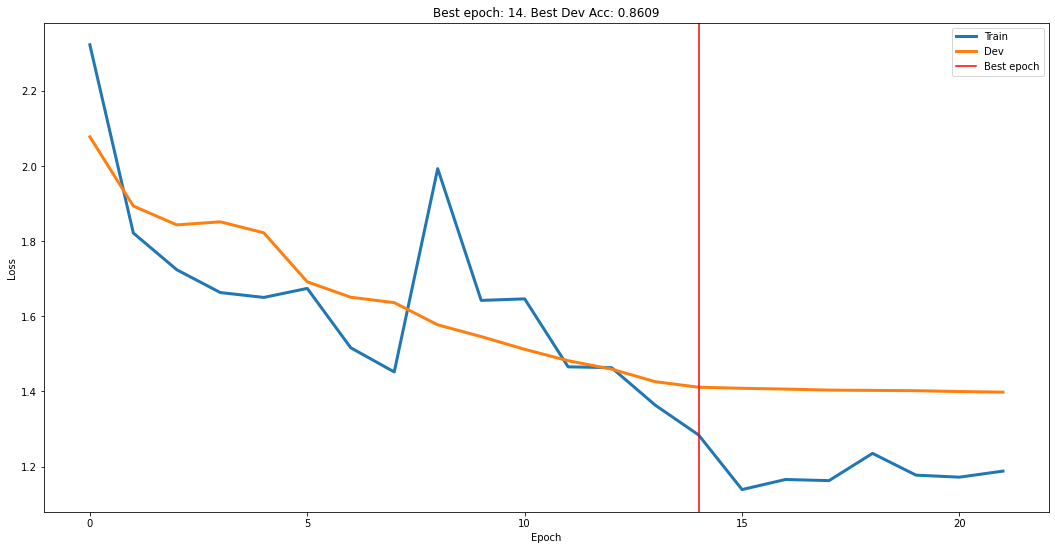


--------------------------------------------------------------------------------




In [89]:
all_layers_num_epochs = 14

train_epoch_loss_history = history['train_losses']
dev_epoch_loss_history = history['dev_losses']

train_per_class_acc_history = history['train_per_class_accuracies']
dev_per_class_acc_history = history['dev_per_class_accuracies']

dev_epoch_acc_history = history['train_average_accuracies']
train_epoch_acc_history = history['dev_average_accuracies']

best_acc = history['best_acc']
best_epoch =  history['best_epoch']

for epoch in trange(last_layer_num_epochs, last_layer_num_epochs+all_layers_num_epochs, desc='epoch'):
    print('Epoch:', epoch)
    # train
    avg_epoch_loss, avg_per_class_acc = train_one_epoch(iterator=train1_dataloader,
                                                        model=model_ft, criterion=criterion,
                                                        optimizer=optimizer_ft)
    avg_acc = avg_per_class_acc.mean().item()
    train_epoch_acc_history.append(avg_acc)
    print('Train Avg Acc:', avg_acc)
    train_epoch_loss_history.append(avg_epoch_loss)
    train_per_class_acc_history.append(avg_per_class_acc)
    print('Train Loss:', avg_epoch_loss)
    print('Train Accs per class:', avg_per_class_acc)
    print()
    
    # evaluate on the dev set
    avg_epoch_loss, avg_per_class_acc = evaluate(iterator=dev1_dataloader,
                                                 model=model_ft, criterion=criterion)
    avg_acc = avg_per_class_acc.mean().item()
    dev_epoch_acc_history.append(avg_acc)
    print('Dev Avg Acc:', avg_acc)
    dev_epoch_loss_history.append(avg_epoch_loss)
    dev_per_class_acc_history.append(avg_per_class_acc)
    print('Dev Loss:', avg_epoch_loss)
    print('Dev Accs per class:', avg_per_class_acc)
    
    if (not best_acc) or avg_acc > best_acc:
        best_epoch = epoch
        best_acc = avg_acc
        
        best_model_wts = copy.deepcopy(model_ft.state_dict())

    # lr scheduler step
    exp_lr_scheduler.step()

    # plot
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_epoch_loss_history)), train_epoch_loss_history, label=f'Train', linewidth=3)
    plt.plot(np.arange(len(dev_epoch_loss_history)), dev_epoch_loss_history, label=f'Dev', linewidth=3)
    plt.axvline(x=best_epoch, label='Best epoch', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Best epoch: {best_epoch}. Best Dev Acc: {best_acc:.4}')
    plt.legend(loc='best')
    plt.show()


    print()
    print('-'*80)
    print()

### Save weights

In [98]:
%mkdir ../weights

mkdir: cannot create directory ‘../weights’: File exists


In [99]:
torch.save(model_ft.state_dict(), f'../weights/{MODEL_NAME}.pth')

In [100]:
%ls ../weights

 2-layer-head-baseline-2021-06-16.pth
'2-layer-head_dropout=0.5_2021-06-16.pth'
'2-layer-head_dropout=0.5_wd=0.2_2021-06-16.pth'
'2-layer-head_dropout=0.5_wd=1_2021-06-16.pth'
'2-layer-head_dropout=0.8_2021-06-16.pth'
'2-layer-head_dropout=0.8_wd=0.1_2021-06-16.pth'
'2-layer-head_dropout=0.8_wd=1_2021-06-16.pth'
'Adam_wd=0.0001_2021-06-11.pth'
'Adam_wd=0.01_2021-06-11.pth'
'Adam_wd=100_2021-06-11.pth'
'Adam_wd=10_2021-06-11.pth'
'Adam_wd=1_2021-06-11.pth'
'Adam_wd=1e-08_2021-06-11.pth'
 baseline-2021-06-08.pth
 baseline-2021-06-09.pth
 baseline-Adam-2021-06-11.pth
 efficientnet-b2_1-layer-head-finetuned.pth
 efficientnet-b2_baseline_2021-06-17.pth
 efficientnet-b3_1-layer-head-finetuned.pth
 efficientnet-b3_2-layer-head-finetuned.pth
'efficientnet-b3_2-layer-head_p=0.8_2021-06-17.pth'
 efficientnet-b3_baseline_2021-06-17.pth
 README.md
 resnet18_2-layer-head_strong-aug_Adam_last-2-layers-finetuned.pth
 resnet18-strong-aug-Adam-last-layer-finetuned.pth
 strong-aug-Adam-2021-06-14.pth
 s

## Save history

In [101]:
%mkdir ../history

mkdir: cannot create directory ‘../history’: File exists


In [102]:
train_per_class_acc_history

[[0.800000011920929, 0.800000011920929, 0.760937511920929, 0.6812499761581421],
 [0.8359375, 0.856249988079071, 0.7953125238418579, 0.739062488079071],
 [0.8359375, 0.875, 0.7828124761581421, 0.7796875238418579],
 [0.839062511920929,
  0.8687499761581421,
  0.8140624761581421,
  0.7828124761581421],
 [0.848437488079071,
  0.8734375238418579,
  0.792187511920929,
  0.7796875238418579],
 [0.8203125, 0.862500011920929, 0.828125, 0.7796875238418579],
 [0.8609374761581421, 0.8687499761581421, 0.8515625, 0.792187511920929],
 [0.8500000238418579, 0.871874988079071, 0.8453124761581421, 0.8125],
 tensor([0.8281, 0.8188, 0.7984, 0.7359]),
 tensor([0.8281, 0.8859, 0.8219, 0.7953]),
 tensor([0.8109, 0.8531, 0.8406, 0.7937]),
 tensor([0.8734, 0.8891, 0.8375, 0.8234]),
 tensor([0.8422, 0.8766, 0.8578, 0.8125]),
 tensor([0.8766, 0.8953, 0.8687, 0.7984]),
 tensor([0.8906, 0.8828, 0.8703, 0.8359]),
 tensor([0.8687, 0.9125, 0.8766, 0.8594]),
 tensor([0.9000, 0.9109, 0.8750, 0.8453]),
 tensor([0.8813, 0.

In [103]:
history = {
    'train_losses': [float(el) for el in train_epoch_loss_history],
    'dev_losses': [float(el) for el in dev_epoch_loss_history],

    'train_per_class_accuracies': [list(torch.tensor(el).numpy().astype(float)) for el in train_per_class_acc_history],
    'dev_per_class_accuracies': [list(torch.tensor(el).numpy().astype(float)) for el in dev_per_class_acc_history],

    'train_average_accuracies': [float(el) for el in train_epoch_acc_history],
    'dev_average_accuracies': [float(el) for el in dev_epoch_acc_history],
    
    'best_epoch': best_epoch,
    'best_acc': best_acc
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [104]:
with open(f'../history/{MODEL_NAME}.json', 'w') as f:
    json.dump(history, f)

In [105]:
%ls ../history

 2-layer-head-baseline-2021-06-16.json
'2-layer-head_dropout=0.5_2021-06-16.json'
'2-layer-head_dropout=0.5_wd=0.2_2021-06-16.json'
'2-layer-head_dropout=0.5_wd=1_2021-06-16.json'
'2-layer-head_dropout=0.8_2021-06-16.json'
'2-layer-head_dropout=0.8_wd=0.1_2021-06-16.json'
'2-layer-head_dropout=0.8_wd=1_2021-06-16.json'
'Adam_wd=0.0001_2021-06-11.json'
'Adam_wd=0.01_2021-06-11.json'
'Adam_wd=100_2021-06-11.json'
'Adam_wd=10_2021-06-11.json'
'Adam_wd=1_2021-06-11.json'
'Adam_wd=1e-08_2021-06-11.json'
 baseline-2021-06-08.json
 baseline-2021-06-09.json
 baseline-Adam-2021-06-11.json
 dummy-classifier.json
 efficientnet-b2_1-layer-head-finetuned.json
 efficientnet-b2_baseline_2021-06-17.json
 efficientnet-b3_1-layer-head-finetuned.json
 efficientnet-b3_2-layer-head-finetuned.json
'efficientnet-b3_2-layer-head_p=0.8_2021-06-17.json'
 efficientnet-b3_baseline_2021-06-17.json
 resnet18_2-layer-head_strong-aug_Adam_last-2-layers-finetuned.json
 resnet18-strong-aug-Adam-last-layer-finetuned.jso